# Figure 9 - Water dissociation
This Jupyter notebooks reproduces Figure 9. The output .png and .pdf files are saved in <em>/figures</em>. 1D spectra with and without water dissociation to show there is a negligible difference between them for our 1D retrieved P-T range.

In [18]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from astropy.io import fits
import pickle
import h5py

In [19]:
def flux_density_wav2freq(flux_density_wl, wl):
    """All units must be cgs units for this to work."""
    c = 2.998e10 # cm / s
    flux_density_freq = flux_density_wl * ( wl**2 / c )
    return flux_density_freq

def conv2instr(f, vbroad, vinst=6.6):
    if vinst == 0. and vbroad == 0.:
        return f
    FWHM = 125e3 / ( 2.99792e5 / (vinst+vbroad) )
    xker = np.arange(41)-20
    sigma = FWHM/(2. * np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0) # Gaussian
    yker /= yker.sum() # Normalised Gaussian
    f_conv = np.convolve(f, yker, mode='same')
    return f_conv

Pick one of the models to plot to check if it is approximately at the right temperature by black body comparison.

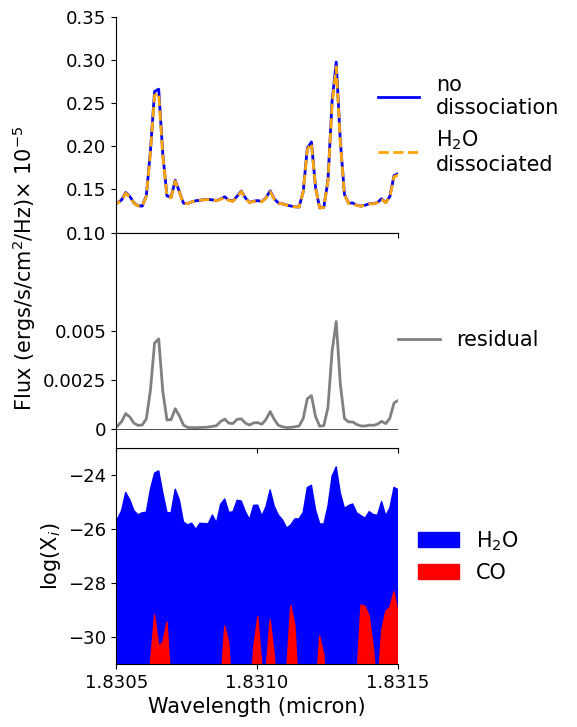

In [23]:
%matplotlib inline
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from scipy import interpolate
cmap = colormaps['plasma']
c_list = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]

plt.close()
fig = plt.figure(figsize=(5.,5.*1.68))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[0.33,0.33,0.33], width_ratios=[1.,0.25], hspace=0.)
ax = fig.add_subplot(gs[0,0])
lax = fig.add_subplot(gs[0,1])

ax2 = fig.add_subplot(gs[2,0])
lax2 = fig.add_subplot(gs[2,1])

ax3 = fig.add_subplot(gs[1,0])
lax3 = fig.add_subplot(gs[1,1])


ax2.set_xlabel('Wavelength (micron)', size=15)
ax3.set_ylabel(' '*22+ r'Flux (ergs/s/cm$^2$/Hz)' r'$\times$ 10$^{-5}$', size=15)

dvsys= 0# -1.8 
dKp= 0#2.7
RV = dvsys + dKp * np.sin(0.59)
dl_l = RV / 2.99792e5

model_list = ['../data/spectra/fm_dopon.pic', '../data/spectra/fm_dopon_H2O_dissociated.pic']
c_list = ['b', 'orange']
label_list = ['no\ndissociation', 'H$_2$O'+'\ndissociated']
ls_list = ['-', '--']
fluxes = []
for model, c, l, ls in zip(model_list, c_list, label_list, ls_list):
    wn, flux = pickle.load(open(model, 'rb'))
    wl = 1e4/wn
    flux = flux_density_wav2freq(flux*(1e2)**-3, wl*1e-4) * 1e7

    wShift = wl * (1.0 - dl_l)
    flux = conv2instr(flux, vbroad=3.9, vinst=0)
    cs_p = interpolate.splrep(wl[::-1], flux[::-1])
    flux = interpolate.splev(wShift, cs_p, der=0)

    ax.plot(wl, flux/1e-5, color=c, lw=2, label=l, ls=ls)
    fluxes.append(flux)
    
ax3.plot(wl, (fluxes[0]-fluxes[1])/1e-5, color='gray', lw=2, label='residual')

files = ['', '']
colors = ['b', 'r']
opacities = [r'H$_2$O', 'CO']
for opacity, color, file in zip(opacities, colors, files):
    if opacity == 'CO':
        d = pickle.load(open('../data/opacities/fig9_CO.pkl', 'rb'))
        ax2.fill_between(d[0], d[1], -99, label=f'{opacity}', alpha=1, color=f'{color}')
    if opacity == r'H$_2$O':
        d = pickle.load(open('../data/opacities/fig9_H2O.pkl', 'rb'))
        ax2.fill_between(d[0], d[1], -99, label=f'{opacity}', alpha=1, color=f'{color}')

ax2.set_ylabel(f'log(X$_i$)', size=15)
ax2.set_ylim(-31,-23)
xmin = 1.8305
xmax = 1.8315

ax.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)
ax3.set_xlim(xmin,xmax)

ax2.set_yticks([-30,-28,-26, -24])

ax.spines['top'].set_visible(False) 
ax2.spines['right'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax.spines['right'].set_visible(False)
lax.axis('off')
lax2.axis('off')
lax3.axis('off')


ax.set_ylim(0.1, 0.35)

ax.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=15)
ax2.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=15)
ax3.legend(bbox_to_anchor = (1.25, 0.5), facecolor='white', framealpha=1., loc='center', frameon=False, fontsize=15)

ax3.set_xticks([1.8305, 1.831, 1.8315])
ax.set_xticks([1.8305, 1.831, 1.8315])
ax2.set_xticks([1.8305, 1.831, 1.8315])


ax.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax3.tick_params(axis='both', which='major', labelsize=13)

ax3.set_ylim(-0.001,0.01)
ax3.set_xticklabels([])
ax.set_xticklabels([])
ax3.set_yticks([0, 0.0025,0.005])
ax3.set_yticklabels([0, 0.0025, 0.005])
ax3.axhline(y=0, ls='-', lw=0.5, color='k')

dirout='../figures/'
plt.savefig(os.path.join(dirout, f'Fig9_water_dissociation.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(dirout, f'Fig9_water_dissociation.pdf'), bbox_inches='tight')
plt.show()